In [54]:
!pip install colorcet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/260.3 kB ? eta -:--:--
   ---------------------------------- ----- 225.3/260.3 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 260.3/260.3 kB 4.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: C:\Users\shrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Load mathematica data
Parser function

In [30]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataB0LFIMJx_large.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


Shape: (10000, 15)
[0.0017074  0.01025427 0.00858844 0.04876119 0.01178353 0.02010032
 0.05569278 0.09110392 0.02350792 0.01505585 0.06550871 0.00708423
 0.01390895 0.00577767 0.17899025]


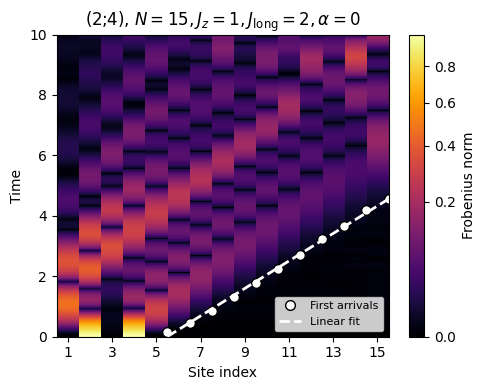

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
     (5, 0.16), (6, 0.46), (7, 0.84), (8, 1.31), (9, 1.77),
        (10, 2.23), (11, 2.72), (12, 3.22), (13, 3.66),
        (14, 4.18), (15, 4.55)]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="inferno",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $N=15, J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("N15B0LFIMEmergentHfullb1lc.png", bbox_inches="tight") 
plt.show()


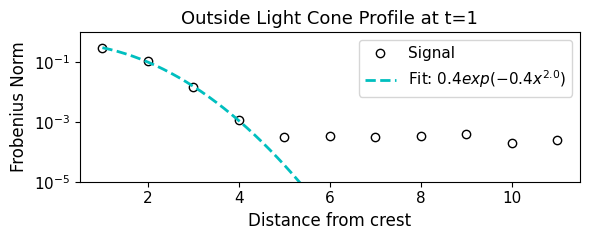

In [222]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("N15B0LFIMEmergentHfullb1lcOutLC.svg", bbox_inches="tight") 
plt.show()


In [34]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataB0LFIMJx_small.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


Shape: (1000, 15)
[3.05539934e-03 4.92673818e-02 3.07919399e-02 8.55669911e-02
 8.24661366e-02 6.08041676e-03 1.73578626e-02 5.37943043e-03
 2.12621258e-02 5.19207398e-05 4.91669412e-03 8.89933289e-03
 8.24355402e-03 1.35014584e-02 1.24984183e-02]


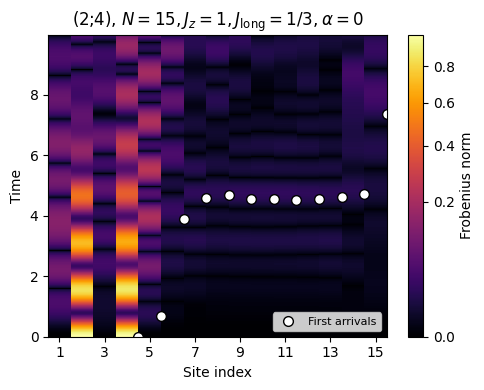

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (4, 0.0), (5, 0.7), (6, 3.89), (7, 4.58), (8, 4.67),
    (9, 4.54), (10, 4.54), (11, 4.53), (12, 4.56),
    (13, 4.61), (14, 4.73), (15, 7.37)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="inferno",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# # Overlay best-fit line
# plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $N=15, J_z=1, J_{\mathrm{long}}=1/3, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("N15B0LFIMEmergentHfullb1lc2.svg", bbox_inches="tight") 
plt.show()


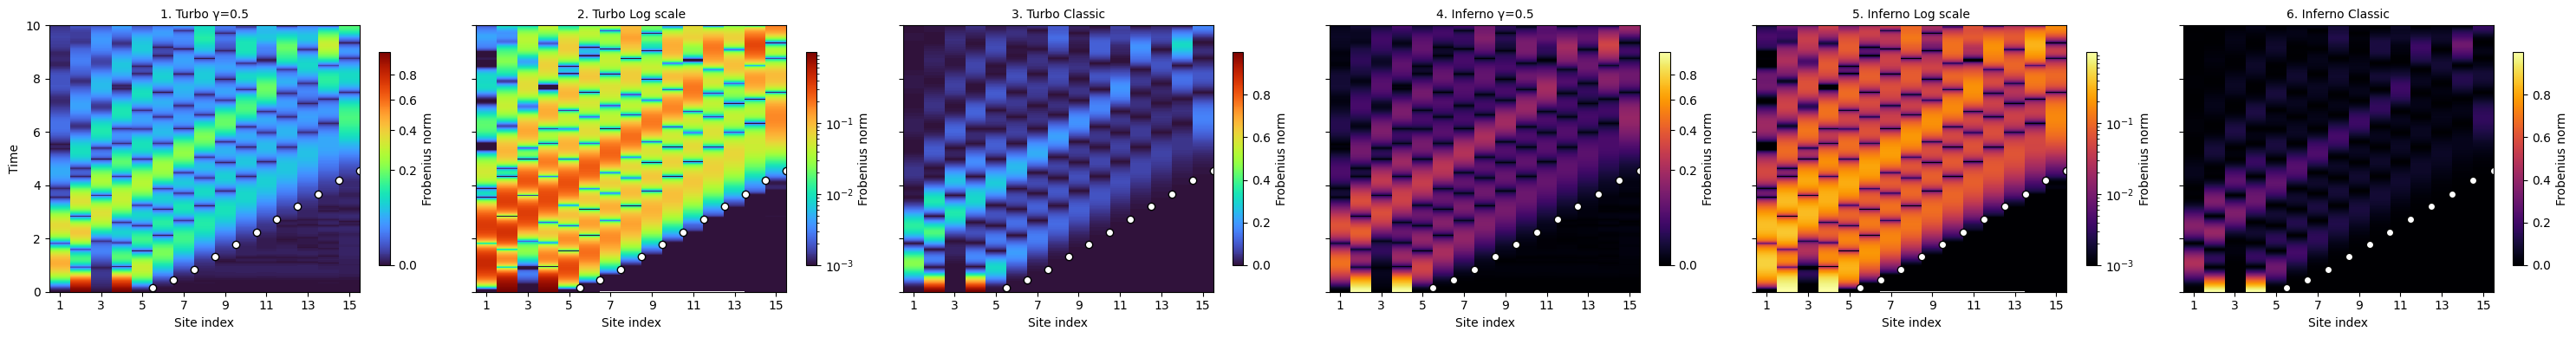

In [33]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np

# --- Dummy data (replace with your raw_data) ---
# np.random.seed(0)
# raw_data = np.abs(np.random.randn(500, 15))**2  # Example Frobenius-like values

# === First arrival points ===
arrivals = [
     (5, 0.16), (6, 0.46), (7, 0.84), (8, 1.31), (9, 1.77),
        (10, 2.23), (11, 2.72), (12, 3.22), (13, 3.66),
        (14, 4.18), (15, 4.55)]


x_points = np.array([a[0] for a in arrivals])
y_points = np.array([a[1] for a in arrivals])

# === Simulation step size ===
step_size = 0.001
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Settings for 6 subplots (turbo + inferno, 3 modes each) ===
plot_settings = [
    {"cmap": "turbo", "norm": mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
     "title": "1. Turbo γ=0.5"},
    {"cmap": "turbo", "norm": mcolors.LogNorm(vmin=1e-3, vmax=raw_data.max()),
     "title": "2. Turbo Log scale"},
    {"cmap": "turbo", "norm": mcolors.Normalize(vmin=0, vmax=raw_data.max()),
     "title": "3. Turbo Classic"},
    {"cmap": "inferno", "norm": mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
     "title": "4. Inferno γ=0.5"},
    {"cmap": "inferno", "norm": mcolors.LogNorm(vmin=1e-3, vmax=raw_data.max()),
     "title": "5. Inferno Log scale"},
    {"cmap": "inferno", "norm": mcolors.Normalize(vmin=0, vmax=raw_data.max()),
     "title": "6. Inferno Classic"},
]

fig, axes = plt.subplots(1, 6, figsize=(30, 4), sharey=True)

for ax, setting in zip(axes, plot_settings):
    im = ax.imshow(
        raw_data,
        aspect="auto",
        origin="lower",
        cmap=setting["cmap"],
        interpolation="none",
        norm=setting["norm"],
        extent=[0, raw_data.shape[1], t_min, t_max+0.001]
    )

    # Overlay first arrival points
    ax.plot(x_points, y_points, 'wo', markersize=6,
            markeredgecolor="k", label="First arrivals")

    ax.set_title(setting["title"], fontsize=10)
    ax.set_xlabel("Site index")

    # Fix site index ticks
    n_sites = raw_data.shape[1]
    step = 2
    positions = np.arange(0.5, n_sites, step)
    labels = np.arange(1, n_sites + 1, step)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)

    # Individual colorbar for each plot
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Frobenius norm")

axes[0].set_ylabel("Time")

plt.tight_layout()
plt.savefig("turbo_inferno_comparison_6plots.svg", bbox_inches="tight")
plt.show()


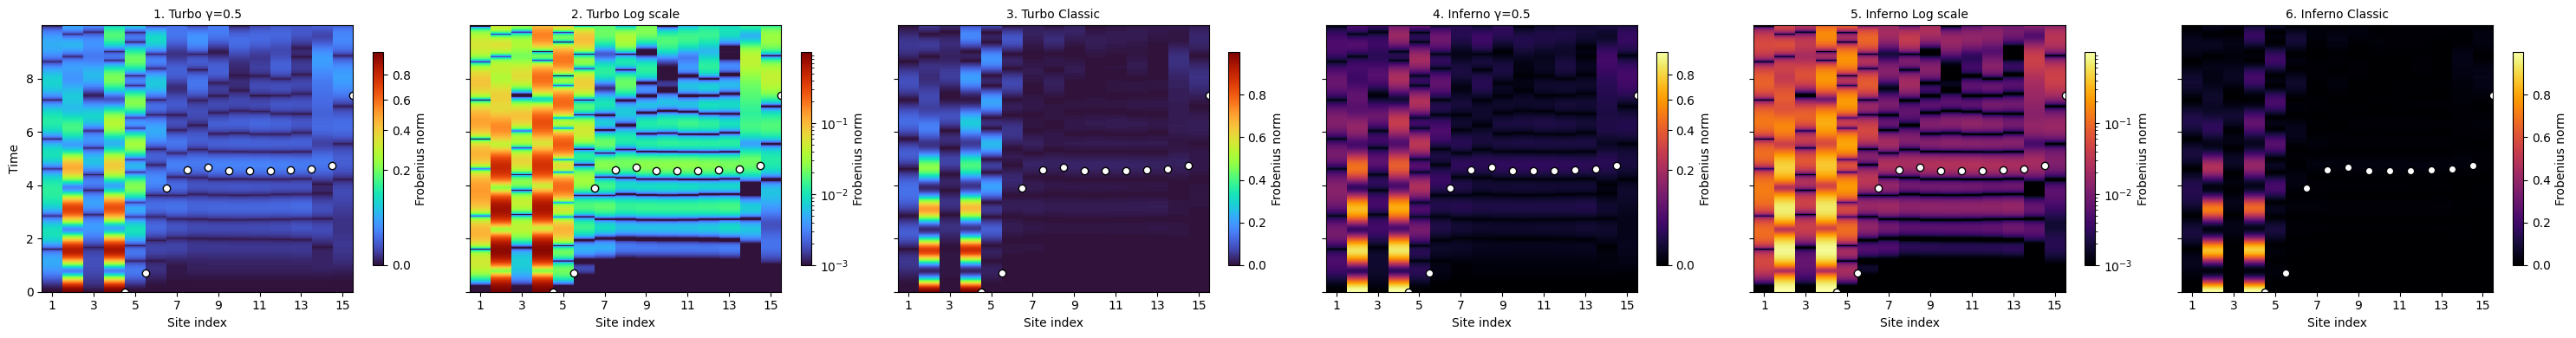

In [35]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np

# --- Dummy data (replace with your raw_data) ---
# np.random.seed(0)
# raw_data = np.abs(np.random.randn(500, 15))**2  # Example Frobenius-like values

# === First arrival points ===
arrivals = [
    (4, 0.0), (5, 0.7), (6, 3.89), (7, 4.58), (8, 4.67),
    (9, 4.54), (10, 4.54), (11, 4.53), (12, 4.56),
    (13, 4.61), (14, 4.73), (15, 7.37)
]

x_points = np.array([a[0] for a in arrivals])
y_points = np.array([a[1] for a in arrivals])

# === Simulation step size ===
step_size = 0.01
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Settings for 6 subplots (turbo + inferno, 3 modes each) ===
plot_settings = [
    {"cmap": "turbo", "norm": mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
     "title": "1. Turbo γ=0.5"},
    {"cmap": "turbo", "norm": mcolors.LogNorm(vmin=1e-3, vmax=raw_data.max()),
     "title": "2. Turbo Log scale"},
    {"cmap": "turbo", "norm": mcolors.Normalize(vmin=0, vmax=raw_data.max()),
     "title": "3. Turbo Classic"},
    {"cmap": "inferno", "norm": mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
     "title": "4. Inferno γ=0.5"},
    {"cmap": "inferno", "norm": mcolors.LogNorm(vmin=1e-3, vmax=raw_data.max()),
     "title": "5. Inferno Log scale"},
    {"cmap": "inferno", "norm": mcolors.Normalize(vmin=0, vmax=raw_data.max()),
     "title": "6. Inferno Classic"},
]

fig, axes = plt.subplots(1, 6, figsize=(30, 4), sharey=True)

for ax, setting in zip(axes, plot_settings):
    im = ax.imshow(
        raw_data,
        aspect="auto",
        origin="lower",
        cmap=setting["cmap"],
        interpolation="none",
        norm=setting["norm"],
        extent=[0, raw_data.shape[1], t_min, t_max+0.001]
    )

    # Overlay first arrival points
    ax.plot(x_points, y_points, 'wo', markersize=6,
            markeredgecolor="k", label="First arrivals")

    ax.set_title(setting["title"], fontsize=10)
    ax.set_xlabel("Site index")

    # Fix site index ticks
    n_sites = raw_data.shape[1]
    step = 2
    positions = np.arange(0.5, n_sites, step)
    labels = np.arange(1, n_sites + 1, step)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)

    # Individual colorbar for each plot
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Frobenius norm")

axes[0].set_ylabel("Time")

plt.tight_layout()
plt.savefig("turbo_inferno_comparison_6plots2.svg", bbox_inches="tight")
plt.show()
